# Converting Deterministic Assumptions to Random Variables 

The excel model uses point assumptions for the following: 
- Rent Growth 
- Vacancy Rate 
- Interest Rate

For monte carlo simulation, these drivers are modelled as random variables with: 
- Mean (central tendency)
- Dispersion (volatility) 
- Sensible bounds 

This notebook defines distributions for 
1) Rent Growth 
2) Vacancy Rate 
3) Interest Rate Changes 

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt  

rng = np.random.default_rng(42)

def summarize(x: np.ndarray, name: str):
    s = pd.Series(x).describe(percentiles=[0.01,0.05,0.5,0.95,0.99])
    print(f"\{name}")
    display(s)

<string>:9: SyntaxWarning: invalid escape sequence '\{'
<>:9: SyntaxWarning: invalid escape sequence '\{'
<string>:9: SyntaxWarning: invalid escape sequence '\{'
<>:9: SyntaxWarning: invalid escape sequence '\{'
C:\Users\trabi\AppData\Local\Temp\ipykernel_29828\2685893590.py:9: SyntaxWarning: invalid escape sequence '\{'
  print(f"\{name}")


## Rent Growth Distribution 

Annual rent growth will be modelled as a random variable. 

Mean and volatility will be estimated from historical YoY rent growth data. 

In [4]:
path = "../data/raw/abs_cpi_rents.csv"
raw = pd.read_csv(path, skiprows=1) #header row is not needed 
raw.head(20)

,Unnamed: 0,Annual (RHS) (%),Monthly (LHS) (%)
0,Sep-22,2.9,0.5
1,Oct-22,3.5,0.6
2,Nov-22,3.6,0.2
3,Dec-22,4.1,0.5
4,Jan-23,4.8,0.7
5,Feb-23,4.8,0.7
6,Mar-23,5.3,0.5
7,Apr-23,6.1,0.8
8,May-23,6.3,0.8
9,Jun-23,7.3,0.9


In [5]:
df = raw.rename(columns={raw.columns[0]: "Date","Annual (RHS) (%)": "rent_growth_yoy"})[["Date", "rent_growth_yoy"]].copy()

df["Date"] = pd.to_datetime(df["Date"], format="%b-%y", errors="coerce")

df["rent_growth_yoy"] = pd.to_numeric(df["rent_growth_yoy"], errors="coerce") / 100.0 #convert % to decimal

df = df.dropna(subset=["Date", "rent_growth_yoy"]).sort_values("Date").reset_index(drop=True)

df.head(10)

,Date,rent_growth_yoy
0,2022-09-01,0.029
1,2022-10-01,0.035
2,2022-11-01,0.036
3,2022-12-01,0.041
4,2023-01-01,0.048
5,2023-02-01,0.048
6,2023-03-01,0.053
7,2023-04-01,0.061
8,2023-05-01,0.063
9,2023-06-01,0.073


In [6]:
rent_df = df.copy()
rent_df.head()

,Date,rent_growth_yoy
0,2022-09-01,0.029
1,2022-10-01,0.035
2,2022-11-01,0.036
3,2022-12-01,0.041
4,2023-01-01,0.048


In [8]:
rent_series = rent_df["rent_growth_yoy"].dropna()
mu_rent = float(rent_series.mean()) #mean
sigma_rent = float(rent_series.std(ddof=1)) #std dev

mu_rent, sigma_rent

(0.05916216216216215, 0.014861421932704214)

In [9]:
#defining the bounds and draw samples 
rent_growth_min = -0.05
rent_growth_max = 0.15

def draw_rent_growth(n: int) -> np.ndarray:
    x = rng.normal(mu_rent,sigma_rent,size=n)
    return np.clip(x, rent_growth_min, rent_growth_max)

rent_draws = draw_rent_growth(10_000)
summarize(rent_draws, "Rent Growth Draws (Annual)")

\Rent Growth Draws (Annual)


count    10000.000000
mean         0.059010
std          0.014956
min         -0.006066
1%           0.023884
5%           0.034283
50%          0.058966
95%          0.083576
99%          0.094173
max          0.118992
dtype: float64

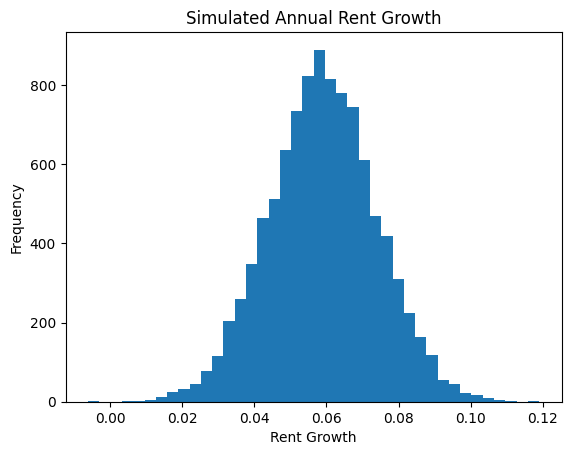

In [10]:
plt.figure()
plt.hist(rent_draws, bins=40)
plt.title("Simulated Annual Rent Growth")
plt.xlabel("Rent Growth")
plt.ylabel("Frequency")
plt.show()

## Vacancy Rate as a Random Variable 

Since vacancy rate is bounded between 0 and 1, a beta distribution will be used. 


In [13]:
vac_mean = 0.013 #model's base vacancy is 1.3%
vac_std = 0.007 #assuming std dev is 0.7%

#converting mean and std to alpha/beta for beta distribution 
var = vac_std**2
max_var = vac_mean * (1-vac_mean)
if var >= max_var: 
    raise ValueError("vac_std is too large for a beta distribution at this mean.")

alpha = vac_mean * (vac_mean*(1-vac_mean)/var -1)
beta  = (1 - vac_mean) * (vac_mean*(1 - vac_mean)/var - 1)

alpha, beta

(3.391142857142856, 257.4659999999999)

In [14]:
#draw vacancy 
def draw_vacancy(n: int) -> np.ndarray:
    return rng.beta(alpha, beta, size=n)

vac_draws = draw_vacancy(10_000)
summarize(vac_draws, "Vacancy Rate Draws")

\Vacancy Rate Draws


count    10000.000000
mean         0.013055
std          0.007064
min          0.000697
1%           0.002236
5%           0.003943
50%          0.011842
95%          0.026274
99%          0.034383
max          0.060255
dtype: float64

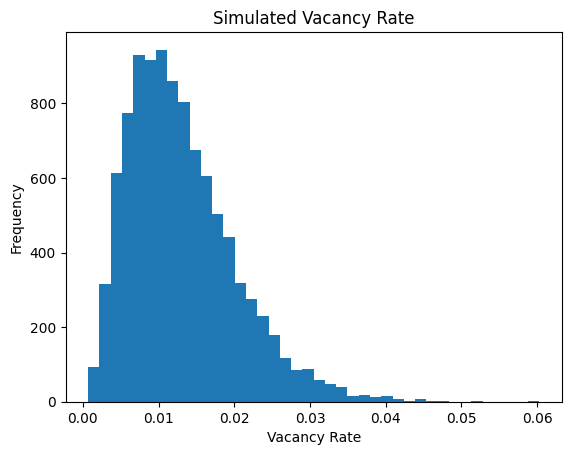

In [15]:
plt.figure()
plt.hist(vac_draws, bins=40)
plt.title("Simulated Vacancy Rate")
plt.xlabel("Vacancy Rate")
plt.ylabel("Frequency")
plt.show()

## Interest Rates as a Random Variable 


In [17]:
rba_raw = pd.read_excel("../data/raw/rba_cash_rate.xlsx")
rba_raw.head()

,F1 INTEREST RATES AND YIELDS – MONEY MARKET,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17
0,Title,Cash Rate Target,Change in the Cash Rate Target,Interbank Overnight Cash Rate,Highest Interbank Overnight Cash Rate,Lowest Interbank Overnight Cash Rate,Volume of Cash Market Transactions,Number of Cash Market Transactions,Total Return Index,EOD 1-month BABs/NCDs,EOD 3-month BABs/NCDs,EOD 6-month BABs/NCDs,1-month OIS,3-month OIS,6-month OIS,1-month Treasury Note,3- month Treasury Note,6- month Treasury Note
1,Description,Cash Rate Target on date,Change in the Cash Rate Target (in percentage ...,Interbank Overnight Cash Rate on date,Highest Interbank Overnight Cash Rate on date,Lowest Interbank Overnight Cash Rate on date,Volume of Interbank Overnight Cash Market Tran...,Number of Interbank Overnight Cash Market Tran...,Cash Rate Total Return Index on date,Bank Accepted Bills/Negotiable Certificates of...,Bank Accepted Bills/Negotiable Certificates of...,Bank Accepted Bills/Negotiable Certificates of...,Overnight Indexed Swaps-1 month,Overnight Indexed Swaps-3 months,Overnight Indexed Swaps-6 months,Treasury Note-1 month,Treasury Note-3 month,Treasury Note-6 month
2,Frequency,Daily,as announced,Daily,Daily,Daily,Daily,Daily,Daily,Daily,Daily,Daily,Daily,Daily,Daily,Daily,Daily,Daily
3,Type,Original,Original,Original,Original,Original,Original,Original,Original,Original,Original,Original,Original,Original,Original,Original,Original,Original
4,Units,Per cent,Per cent,Per cent,Per cent,Per cent,$m,Number,Index 04-Jan-2011=100,Per cent,Per cent,Per cent,Per cent,Per cent,Per cent,Per cent,Per cent,Per cent


In [18]:
rba_raw = pd.read_excel("../data/raw/rba_cash_rate.xlsx", skiprows=10)
rba = rba_raw.iloc[:, [0, 1]].copy()
rba.columns = ["Date", "cash_rate"]

rba["Date"] = pd.to_datetime(rba["Date"], errors="coerce")
rba["cash_rate"] = pd.to_numeric(rba["cash_rate"], errors="coerce") / 100.0

rba = rba.dropna().sort_values("Date").reset_index(drop=True)
rba.head(20)

,Date,cash_rate
0,2011-01-04,0.0475
1,2011-01-05,0.0475
2,2011-01-06,0.0475
3,2011-01-07,0.0475
4,2011-01-10,0.0475
5,2011-01-11,0.0475
6,2011-01-12,0.0475
7,2011-01-13,0.0475
8,2011-01-14,0.0475
9,2011-01-17,0.0475


In [19]:
rba_monthly = (rba.set_index("Date").resample("M").mean().reset_index())
rba_monthly.head(20)

C:\Users\trabi\AppData\Local\Temp\ipykernel_29828\2106739903.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  rba_monthly = (rba.set_index("Date").resample("M").mean().reset_index())


,Date,cash_rate
0,2011-01-31,0.047500
1,2011-02-28,0.047500
2,2011-03-31,0.047500
3,2011-04-30,0.047500
4,2011-05-31,0.047500
5,2011-06-30,0.047500
6,2011-07-31,0.047500
7,2011-08-31,0.047500
8,2011-09-30,0.047500
9,2011-10-31,0.047500


In [20]:
rba_monthly["Date"] = rba_monthly["Date"].dt.to_period("M").dt.to_timestamp(how="start")

In [21]:
rba_monthly

,Date,cash_rate
0,2011-01-01,0.0475
1,2011-02-01,0.0475
2,2011-03-01,0.0475
3,2011-04-01,0.0475
4,2011-05-01,0.0475
...,...,...
176,2025-09-01,0.0360
177,2025-10-01,0.0360
178,2025-11-01,0.0360
179,2025-12-01,0.0360


In [23]:
#estimating monthly changes 
rate_series = rba_monthly["cash_rate"].dropna().sort_index()

rate_change = rate_series.diff().dropna()

mu_dr = float(rate_change.mean())
sigma_dr = float(rate_change.std(ddof=1))

mu_dr, sigma_dr

(-6.388888888888887e-05, 0.0012193649477954308)

In [24]:
dr_min = -0.01
dr_max = 0.01

def draw_rate_changes(n: int) -> np.ndarray: 
    dr = rng.normal(mu_dr, sigma_dr, size=n)
    return np.clip(dr, dr_min, dr_max)

dr_draws = draw_rate_changes(10_000)
summarize(dr_draws, "Monthly Cash Rate Change Draws")

\Monthly Cash Rate Change Draws


count    10000.000000
mean        -0.000070
std          0.001221
min         -0.004828
1%          -0.002935
5%          -0.002082
50%         -0.000071
95%          0.001959
99%          0.002775
max          0.005040
dtype: float64

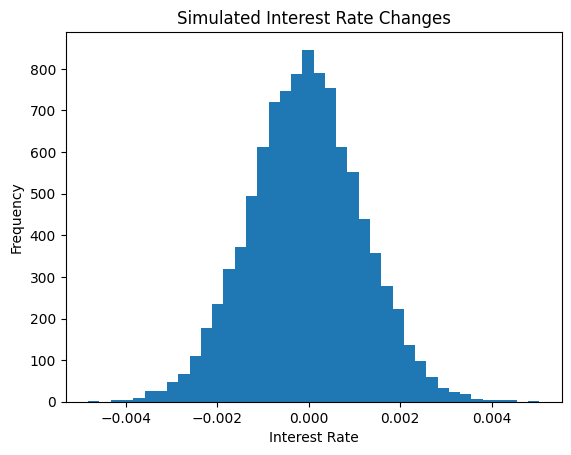

In [25]:
plt.figure()
plt.hist(dr_draws, bins=40)
plt.title("Simulated Interest Rate Changes")
plt.xlabel("Interest Rate")
plt.ylabel("Frequency")
plt.show()

Comparing the simulation distributions against excel assumptions to ensure that random variables are plausible 

In [30]:
sanity = pd.DataFrame({
    "Driver": ["Rent growth (Annual)", "Vacancy Rate", "Cash Rate Change (Monthly)"],
    "Excel Base": [0.0630,0.013, np.nan],
    "Sim Mean": [rent_draws.mean(), vac_draws.mean(),dr_draws.mean()],
    "Sim Std": [rent_draws.std(ddof=1), vac_draws.std(ddof=1), dr_draws.std(ddof=1)]
})

sanity

,Driver,Excel Base,Sim Mean,Sim Std
0,Rent growth (Annual),0.063,0.059010,0.014956
1,Vacancy Rate,0.013,0.013055,0.007064
2,Cash Rate Change (Monthly),NaN,-0.000070,0.001221


The excel model represents the base case expectation, while the monte carlo simulation introduces volatility around the base case to assess downside and tail risk 

# Monte Carlo Simulation 

This section converts the deterministic excel model into a simulation. 

For each simulation: 
1. Simulate annual rent growth 
2. Simulate monthly vacancy rate
3. Simulate monthly interest rate path 
4. Generate monthly cash flows (NOI & Debt Service)
5. Compute exit proceeds and IRR

In [33]:
import numpy_financial as npf

def monthly_irr(cashflows): #compute monthly irr from cash flows
    try: 
        return npf.irr(cashflows)
    except: 
        return np.nan
    
def annual_irr(cashflows): #covert monthly irr to annual irr
    r_m = monthly_irr(cashflows)
    if np.isnan(r_m):
        return np.nan
    return (1 + r_m) ** 12 -1


In [35]:
#Base Model Inputs

#Purchase/Rent Assumptions
purchase_price = 1_050_000
weekly_rent_0 = 759.30

#Operating Expenses (Annual)
opex_annual = 13_877.92

#Financing Assumptions 
lvr = 0.70
loan_0 = 735_000
loan_term_months = 360
rate_0 = 0.0625
repayment_type = "P&I"

#Exit Assumptions 
hold_months = 60
cap_growth = 0.06
sell_cost_pct = 0.02

#Equity Outflow at Time 0 
stamp_duty = 36_750
legal_cost = 3_000
acquisition_cost = stamp_duty + legal_cost

equity_0 = (purchase_price + acquisition_cost) - loan_0

loan_0, equity_0

(735000, 354750)

In [36]:
#Random Drivers 

#Rent Growth (Annual)
mu_rent = 0.063
sigma_rent = 0.02
rent_min, rent_max = -0.15, 0.15

def draw_rent_growth_annual(n_years): 
    g = rng.normal(mu_rent, sigma_rent, size=n_years)
    return np.clip(g, rent_min, rent_max)

#Vacancy Beta Distribution (monthly) 
vac_mean = 0.013
vac_std = 0.007

var = vac_std**2
max_var = vac_mean * (1 - vac_mean)
if var >= max_var: 
    raise ValueError("vac_std is too large for beta distribution at this mean.")

alpha = vac_mean*(vac_mean*(1-vac_mean)/var - 1)
beta = (1 - vac_mean) * (vac_mean*(1-vac_mean)/var-1)

def draw_vacancy_monthly(n_months): 
    return rng.beta(alpha, beta, size=n_months)

#Interest Rate Changes (Monthly)
mu_dr = 0.0
sigma_dr = 0.0025
dr_min, dr_max = -0.01, 0.01

def draw_rate_changes(n_months): 
    dr = rng.normal(mu_dr, sigma_dr, size=n_months)
    return np.clip(dr, dr_min, dr_max)



In [40]:
#Monthly Rent Path 

def weekly_to_monthly(weekly_rent):
    return weekly_rent * 52 /12

def build_monthly_rent_path(weekly_rent_0, annual_growth_by_year, n_months): 
    rent_m = np.zeros(n_months)
    weekly = weekly_rent_0

    month = 0 
    for g_annual in annual_growth_by_year: 
        g_m = (1 + g_annual) ** (1/12) - 1 
        for _ in range(12): 
            if month>=n_months: 
                break 
            rent_m[month]= weekly_to_monthly(weekly)
            weekly *= (1 + g_m)
            month += 1
    return rent_m

In [39]:
#Debt Schedule 
def amortize_variable_rate(balance0, rate_path_annual, term_months, repay_type):
    n = len(rate_path_annual)
    opening = np.zeros(n) 
    interest = np.zeros(n) 
    principal = np.zeros(n) 
    payment = np.zeros(n) 
    closing = np.zeros(n) 

    bal = balance0

    for t in range(n): 
        opening[t] = bal
        r_m = rate_path_annual[t]/12
        interest[t] = bal * r_m

        if repay_type.upper() == "IO": 
            payment[t] = interest[t]
            principal[t] = 0.0
            closing[t] = bal 

        else: 
            remaining = max(term_months - t, 1)

            if abs(r_m) < 1e-12:
                payment[t] = bal / remaining
            else: 
                payment[t] = bal * r_m / (1 - (1 + r_m) ** (remaining))

            principal[t] = payment[t] - interest[t]
            principal_paid = min(principal[t], bal) 
            bal -= principal_paid
            closing[t] = bal

    return {"opening": opening, "interest": interest, "principal": principal, "payment": payment, "closing": closing}

In [43]:
#One Simulation 
def run_one_simulation(): 
    n_years = int(np.ceil(hold_months/12))

    rent_g = draw_rent_growth_annual(n_years)
    vacancy = draw_vacancy_monthly(hold_months)

    dr = draw_rate_changes(hold_months)
    rate_path = np.clip(rate_0 + np.cumsum(dr), 0.0, 0.20)

    #building rent + noi 
    gross_rent = build_monthly_rent_path(weekly_rent_0, rent_g, hold_months)
    eff_rent = gross_rent * (1-vacancy)

    opex_m = opex_annual/12
    noi = eff_rent - opex_m

    #debt 
    debt = amortize_variable_rate(loan_0, rate_path, loan_term_months, repayment_type)
    debt_service = debt["payment"]

    #equity cashflow
    cf_after_debt = noi - debt_service

    #exit proceeds 
    exit_price = purchase_price * ((1+cap_growth) ** (hold_months/12))
    sell_cost = exit_price * sell_cost_pct
    loan_bal_exit = debt["closing"][-1]
    net_sale_proceeds = exit_price - sell_cost - loan_bal_exit

    #total cashflow vector
    cashflows = np.zeros(hold_months + 1)
    cashflows[0] = -equity_0
    cashflows[1:] = cf_after_debt
    cashflows[-1] += net_sale_proceeds

    irr_a = annual_irr(cashflows)

    return irr_a, cashflows, net_sale_proceeds

In [44]:
irr_test, cf_test, nsp_test = run_one_simulation()
irr_test, nsp_test, cf_test[:5]

(0.11942235501245224,
 np.float64(318672.8281452826),
 array([-354750.        ,    2789.9762465 ,    2746.16088752,
           2791.87812941,    2922.45908361]))

In [45]:
#running monte carlo 
n_sims = 5000

irrs = np.empty(n_sims)

for i in range(n_sims): 
    irr_a, _, _ = run_one_simulation()
    irrs[i] = irr_a

irrs = irrs[~np.isnan(irrs)]
len(irrs), np.mean(irrs)

(5000, np.float64(0.10061652191272584))

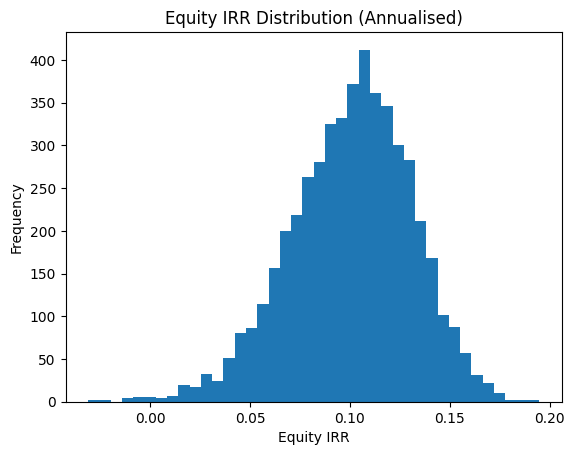

count    5000.000000
mean        0.100617
std         0.030516
min        -0.031000
5%          0.047668
10%         0.060725
50%         0.102893
90%         0.137770
95%         0.147846
max         0.194726
dtype: float64

In [46]:
plt.figure()
plt.hist(irrs, bins=40)
plt.title("Equity IRR Distribution (Annualised)")
plt.xlabel("Equity IRR")
plt.ylabel("Frequency")
plt.show()

summary = pd.Series(irrs).describe(percentiles=[0.05, 0.10, 0.50, 0.90, 0.95])
summary

**Equity IRR Distribution**

The monte carlo simulation reveals that equity returns are best understood as a distribution rather than a single point estimate. 

While the median IRR lies around the base case assumption, the left tail highlights meaningful downside risk under adverse combinations of rent growth, vacancy, and interest rate movements. 

Upside outcomes are bounded, reflecting the cash flow nature of residential real estate assets. 

This probabilistic view enables more informed risk assessment rather than traditional deterministic modelling. 

In [47]:
#downside probability 
prob_neg = np.mean(irrs<0)
prob_neg

np.float64(0.0034)

## Interpretation 

- The histogram summarises the distribution of equity IRR outcomes under uncertainty in rent growth, vacancy, and interest rates. 
- The expected equity return is approximately 10%, with the median (10.29%) slightly higher than the mean (10.06%), indicating a mild downside skew.
- Returns typically vary about 3% around the mean (standard deviation), reflecting moderate macro-driven volatility. 
- The deterministic sensitivity analysis and monte carlo simulation are consistent. The sensitivity table in the excel model identifies structural breakpoints, while monte carlo quantifies the probability of reaching those outcomes.

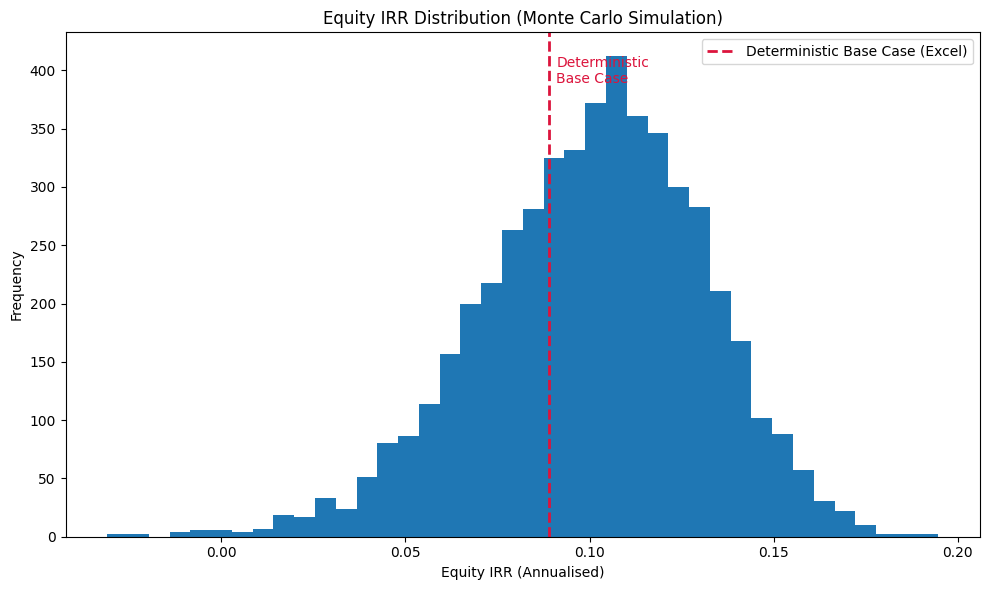

In [53]:
#Linking between excel model and monte carlo 
#deterministic base case IRR is about 9% (0.09)
plt.figure(figsize=(10,6))
plt.hist(irrs, bins=40)
plt.title("Equity IRR Distribution (Monte Carlo Simulation)")
plt.xlabel("Equity IRR (Annualised)")
plt.ylabel("Frequency")

base_case_irr = 0.089
plt.axvline(base_case_irr, color="crimson", linestyle="--",linewidth=2, label="Deterministic Base Case (Excel)")

plt.text(base_case_irr + 0.002, plt.ylim()[1]*0.9, "Deterministic\nBase Case",color="crimson")

plt.legend()
plt.tight_layout()
plt.show()


- The red dashed line is the excel model's base case IRR 
- The distribution shows uncertainty around that point 
- Most outcomes cluster around the deterministic result

The deterministic base case IRR from the excel model is overlaid on the monte carlo IRR distribution. This shows how a single point forecast compares to the full distribution of potential outcomes, highlighting downside tail risk and upsode potential that are not visible in traditional sensitivity analysis. 